# Enunciado do trabalho 2 - individual

Com este trabalho pretende-se que os alunos explorem GANs e/ou Autoencoders num problema à escolha do aluno. Há imensos datasets disponíveis para treinar este tipo de redes.

O objectivo principal é explorar as funções de erro, por exemplo na linha do que foi feito na Pix2Pix ou Cycle GAN, e/ou explorar manipulações e combinações de datasets.

O relatório deve ser sucinto, podendo estar incluído no próprio notebook, e deverá conter a descrição da estratégia definida pelos alunos assim como uma discussão/comparação dos resultados obtidos. No caso da comparação esta deverá ser feita com base em resultados publicados por terceiros.

Submissão via BB.

Data final de submissão: 18 de Junho

https://medium.com/@chloelim608/converting-landscapes-into-minecraft-images-with-cyclegan-dd12c284659b

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.optim as optim
from tqdm import tqdm

import torchinfo

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage

import kagglehub

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


c:\Users\Francisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Componentes do Modelo

https://github.com/henry32144/cyclegan-notebook/blob/master/pytorch_cycle_gan.ipynb

# Download datasets

In [2]:
landscape_dataset = kagglehub.dataset_download(
    "utkarshsaxenadn/landscape-recognition-image-dataset-12k-images"
)
minecraft_dataset = kagglehub.dataset_download(
    "pr1m3r/minecraft-dimensions-screenshots"
)

print(landscape_dataset)
print(minecraft_dataset)

C:\Users\Francisco\.cache\kagglehub\datasets\utkarshsaxenadn\landscape-recognition-image-dataset-12k-images\versions\3
C:\Users\Francisco\.cache\kagglehub\datasets\pr1m3r\minecraft-dimensions-screenshots\versions\3


# Carregar imagens

In [3]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


# Define transforms
transform = transforms.Compose(
    [
        # transforms.Resize((256, 256)),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

landscape_dataset_path = (
    pathlib.Path(landscape_dataset)
    / "Landscape Classification"
    / "Landscape Classification"
    / "Training Data"
)

minecraft_dataset_path = (
    pathlib.Path(minecraft_dataset) / "data" / "nether_comparison_data" / "overworld_sc"
)

print(landscape_dataset_path)
print(minecraft_dataset_path)

# Get image paths
landscape_images = list(landscape_dataset_path.glob("**/*.jpeg"))
minecraft_images = list(minecraft_dataset_path.glob("**/*.png"))

print(f"Found {len(landscape_images)} landscape images")
print(f"Found {len(minecraft_images)} minecraft images")

# Create datasets
landscape_pytorch_dataset = ImageDataset(landscape_images, transform=transform)
minecraft_pytorch_dataset = ImageDataset(minecraft_images, transform=transform)

# Create data loaders
batch_size = 8
landscape_loader = torch.utils.data.DataLoader(
    landscape_pytorch_dataset, batch_size=batch_size, shuffle=True
)
minecraft_loader = torch.utils.data.DataLoader(
    minecraft_pytorch_dataset, batch_size=batch_size, shuffle=True
)

print(
    f"Landscape dataset: {len(landscape_pytorch_dataset)} images, {len(landscape_loader)} batches"
)
print(
    f"Minecraft dataset: {len(minecraft_pytorch_dataset)} images, {len(minecraft_loader)} batches"
)


C:\Users\Francisco\.cache\kagglehub\datasets\utkarshsaxenadn\landscape-recognition-image-dataset-12k-images\versions\3\Landscape Classification\Landscape Classification\Training Data
C:\Users\Francisco\.cache\kagglehub\datasets\pr1m3r\minecraft-dimensions-screenshots\versions\3\data\nether_comparison_data\overworld_sc
Found 10000 landscape images
Found 300 minecraft images
Landscape dataset: 10000 images, 1250 batches
Minecraft dataset: 300 images, 38 batches


Sample landscape images:


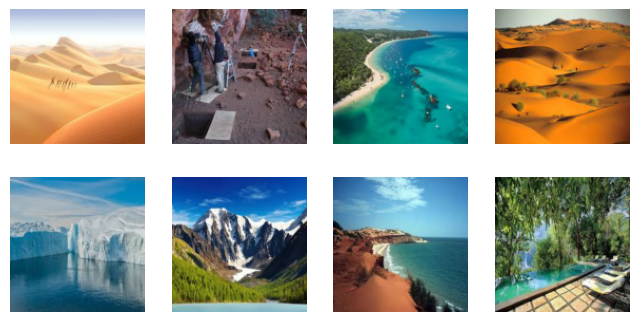

<Figure size 640x480 with 0 Axes>

Sample minecraft images:


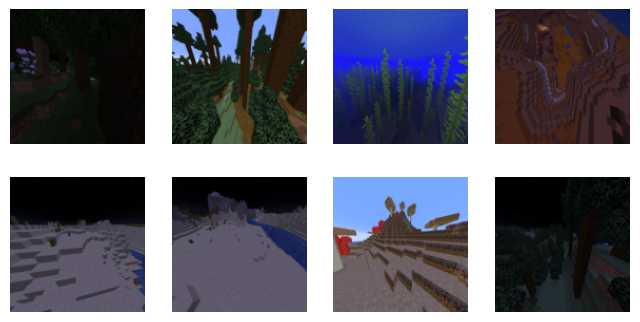

<Figure size 640x480 with 0 Axes>

In [4]:
landscape_batch = next(iter(landscape_loader))
minecraft_batch = next(iter(minecraft_loader))


def show_images(rows, cols, images):
    width = 2 * rows
    height = 2 * cols

    f, axes = plt.subplots(rows, cols, figsize=(height, width))
    fig = plt.figure()

    for a in range(rows * cols):
        axes.ravel()[a].imshow(
            np.clip(np.transpose(images[a].numpy(), (1, 2, 0)) * 0.5 + 0.5, 0, 1),
            cmap=plt.cm.gray,
        )
        axes.ravel()[a].axis("off")
    fig.tight_layout()
    plt.show()


print("Sample landscape images:")
show_images(2, 4, landscape_batch[:8])

print("Sample minecraft images:")
show_images(2, 4, minecraft_batch[:8])

# Generator (CycleGAN)
https://medium.com/@chilldenaya/cyclegan-introduction-pytorch-implementation-5b53913741ca

In [5]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        **kwargs,
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Conv2d(
                in_channels, out_channels, padding_mode="reflect", **kwargs
            )
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, **kwargs)

        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 6
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 6 residual blocks for 128 x 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1-64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1-3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

# Discriminator

In [6]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=4,
            stride=stride,
            padding=1,
            bias=True,
            padding_mode="reflect",
        )
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)
        return self.model(x)

# Training

In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            restore_best_weights (bool): Whether to restore model weights from the epoch with the best value.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_loss, model_states=None):
        if self.best_loss is None:
            self.best_loss = val_loss
            if model_states is not None:
                self.best_weights = self._deep_copy_model_states(model_states)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if model_states is not None:
                self.best_weights = self._deep_copy_model_states(model_states)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def _deep_copy_model_states(self, model_states):
        """Deep copy nested model state dictionaries."""
        return {model_name: {param_name: tensor.clone() for param_name, tensor in state_dict.items()} for model_name, state_dict in model_states.items()}

    def restore_weights(self):
        """Return the best weights if available."""
        return self.best_weights if self.best_weights is not None else None


In [8]:
# Training Configuration
DEVICE = device
LAMBDA_CYCLE = 10.0  # weight for cycle consistency loss
LEARNING_RATE = 2e-4
BETAS = (0.5, 0.999)  # Adam optimizer betas
MAX_EPOCHS = 200

# Resume Training Configuration
LOAD_CHECKPOINT = 110  # Set to epoch number to load (e.g., 70), or None to start from beginning
CHECKPOINT_SAVE_INTERVAL = 10  # Save checkpoint every N epochs

# Early Stopping Configuration
EARLY_STOPPING_PATIENCE = 10  # Number of epochs to wait for improvement
EARLY_STOPPING_MIN_DELTA = 0.001  # Minimum change to qualify as improvement
EARLY_STOPPING_MONITOR = 'cycle_loss'  # Monitor cycle consistency loss

# Create outputs directory if it doesn't exist
os.makedirs("outputs", exist_ok=True)


In [9]:
def find_specific_checkpoint(epoch_num, checkpoint_dir="outputs"):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch_num}.pth")
    
    if os.path.exists(checkpoint_path):
        return checkpoint_path
    else:
        return None


def load_checkpoint(checkpoint_path, models, optimizers, device):
    print(f"Loading checkpoint from: {checkpoint_path}")
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        # Load model states
        models['gen_minecraft'].load_state_dict(checkpoint['gen_minecraft_state_dict'])
        models['gen_landscape'].load_state_dict(checkpoint['gen_landscape_state_dict'])
        models['disc_minecraft'].load_state_dict(checkpoint['disc_minecraft_state_dict'])
        models['disc_landscape'].load_state_dict(checkpoint['disc_landscape_state_dict'])
        
        # Load optimizer states
        optimizers['opt_gen'].load_state_dict(checkpoint['opt_gen_state_dict'])
        optimizers['opt_disc'].load_state_dict(checkpoint['opt_disc_state_dict'])
        
        # Extract checkpoint information
        start_epoch = checkpoint['epoch'] + 1  # +1 because we want to start from the next epoch
        training_history = checkpoint.get('training_history', {
            'epoch': [],
            'discriminator_loss': [],
            'generator_loss': [],
            'cycle_loss': [],
            'minecraft_real_score': [],
            'minecraft_fake_score': []
        })
        
        early_stopping_state = checkpoint.get('early_stopping_state', {})
        
        print(f"   Successfully loaded checkpoint from epoch {checkpoint['epoch']}")
        print(f"   Will resume training from epoch {start_epoch}")
        print(f"   Training history contains {len(training_history.get('epoch', []))} previous epochs")
        
        return {
            'start_epoch': start_epoch,
            'training_history': training_history,
            'early_stopping_state': early_stopping_state
        }
        
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Starting training from scratch...")
        return None


In [10]:
def train_fn(
    disc_minecraft,
    disc_landscape,
    gen_landscape,
    gen_minecraft,
    loader,
    opt_disc,
    opt_gen,
    l1,
    mse,
    d_scaler,
    g_scaler,
    epoch,
):
    """
    Adapted training function for Minecraft-GAN:
    - disc_minecraft: Discriminator for Minecraft domain
    - disc_landscape: Discriminator for Landscape domain
    - gen_landscape: Generator that converts Minecraft -> Landscape
    - gen_minecraft: Generator that converts Landscape -> Minecraft
    
    Returns:
        dict: Dictionary containing average losses for the epoch
    """
    minecraft_reals = 0
    minecraft_fakes = 0
    total_d_loss = 0
    total_g_loss = 0
    total_cycle_loss = 0
    num_batches = 0
    
    loop = tqdm(loader, leave=True)

    for idx, (landscape, minecraft) in enumerate(loop):
        landscape = landscape.to(DEVICE)
        minecraft = minecraft.to(DEVICE)

        # Train discriminators for Minecraft and Landscape domains
        with torch.autocast(device_type="cuda"):
            # Generate fake minecraft from landscape
            fake_minecraft = gen_minecraft(landscape)
            D_minecraft_real = disc_minecraft(minecraft)
            D_minecraft_fake = disc_minecraft(fake_minecraft.detach())
            minecraft_reals += D_minecraft_real.mean().item()
            minecraft_fakes += D_minecraft_fake.mean().item()
            D_minecraft_real_loss = mse(
                D_minecraft_real, torch.ones_like(D_minecraft_real)
            )
            D_minecraft_fake_loss = mse(
                D_minecraft_fake, torch.zeros_like(D_minecraft_fake)
            )
            D_minecraft_loss = D_minecraft_real_loss + D_minecraft_fake_loss

            # Generate fake landscape from minecraft
            fake_landscape = gen_landscape(minecraft)
            D_landscape_real = disc_landscape(landscape)
            D_landscape_fake = disc_landscape(fake_landscape.detach())
            D_landscape_real_loss = mse(
                D_landscape_real, torch.ones_like(D_landscape_real)
            )
            D_landscape_fake_loss = mse(
                D_landscape_fake, torch.zeros_like(D_landscape_fake)
            )
            D_landscape_loss = D_landscape_real_loss + D_landscape_fake_loss

            # Total discriminator loss
            D_loss = (D_minecraft_loss + D_landscape_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generators for both domains
        with torch.autocast(device_type="cuda"):
            # Adversarial losses for generators
            D_minecraft_fake = disc_minecraft(fake_minecraft)
            D_landscape_fake = disc_landscape(fake_landscape)
            loss_G_minecraft = mse(D_minecraft_fake, torch.ones_like(D_minecraft_fake))
            loss_G_landscape = mse(D_landscape_fake, torch.ones_like(D_landscape_fake))

            # Cycle consistency losses
            cycle_landscape = gen_landscape(fake_minecraft)
            cycle_minecraft = gen_minecraft(fake_landscape)
            cycle_landscape_loss = l1(landscape, cycle_landscape)
            cycle_minecraft_loss = l1(minecraft, cycle_minecraft)

            # Total cycle loss
            cycle_loss = cycle_landscape_loss + cycle_minecraft_loss

            # Total generator loss
            G_loss = (
                loss_G_landscape
                + loss_G_minecraft
                + cycle_loss * LAMBDA_CYCLE
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        # Accumulate losses for monitoring
        total_d_loss += D_loss.item()
        total_g_loss += G_loss.item()
        total_cycle_loss += cycle_loss.item()
        num_batches += 1

        if idx == 0 and epoch % 10 == 0:
            save_image(fake_minecraft * 0.5 + 0.5, f"outputs/minecraft_{epoch}.png")
            save_image(fake_landscape * 0.5 + 0.5, f"outputs/landscape_{epoch}.png")

        loop.set_postfix(
            minecraft_real=minecraft_reals / (idx + 1),
            minecraft_fake=minecraft_fakes / (idx + 1),
            d_loss=total_d_loss / (idx + 1),
            g_loss=total_g_loss / (idx + 1),
            cycle_loss=total_cycle_loss / (idx + 1),
        )
    
    # Return average losses for the epoch
    return {
        'discriminator_loss': total_d_loss / num_batches,
        'generator_loss': total_g_loss / num_batches,
        'cycle_loss': total_cycle_loss / num_batches,
        'minecraft_real_score': minecraft_reals / num_batches,
        'minecraft_fake_score': minecraft_fakes / num_batches,
    }


In [11]:
def create_combined_loader(landscape_loader, minecraft_loader, max_batches=None):
    """
    Create a combined data loader that yields pairs of (landscape, minecraft) batches.
    Since the datasets have different sizes, we'll cycle through the smaller one.
    """
    landscape_iter = iter(landscape_loader)
    minecraft_iter = iter(minecraft_loader)
    
    batches_processed = 0
    
    while True:
        try:
            landscape_batch = next(landscape_iter)
        except StopIteration:
            landscape_iter = iter(landscape_loader)
            landscape_batch = next(landscape_iter)
            
        try:
            minecraft_batch = next(minecraft_iter)
        except StopIteration:
            minecraft_iter = iter(minecraft_loader)
            minecraft_batch = next(minecraft_iter)
            
        # Ensure both batches have the same size
        min_size = min(landscape_batch.size(0), minecraft_batch.size(0))
        landscape_batch = landscape_batch[:min_size]
        minecraft_batch = minecraft_batch[:min_size]
        
        yield landscape_batch, minecraft_batch
        
        batches_processed += 1
        if max_batches and batches_processed >= max_batches:
            break


In [12]:
# Initialize models
disc_minecraft = Discriminator(in_channels=3).to(DEVICE)
disc_landscape = Discriminator(in_channels=3).to(DEVICE)
gen_landscape = Generator(img_channels=3, num_features=64).to(DEVICE)  # Minecraft -> Landscape
gen_minecraft = Generator(img_channels=3, num_features=64).to(DEVICE)  # Landscape -> Minecraft

# Initialize optimizers
opt_disc = optim.Adam(
    list(disc_minecraft.parameters()) + list(disc_landscape.parameters()),
    lr=LEARNING_RATE,
    betas=BETAS,
)
opt_gen = optim.Adam(
    list(gen_landscape.parameters()) + list(gen_minecraft.parameters()),
    lr=LEARNING_RATE,
    betas=BETAS,
)

# Loss functions
L1 = nn.L1Loss()
mse = nn.MSELoss()

# Gradient scalers for mixed precision training
g_scaler = torch.amp.GradScaler()
d_scaler = torch.amp.GradScaler()

print("Models and optimizers initialized successfully!")
print(f"Generator parameters: {sum(p.numel() for p in gen_minecraft.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in disc_minecraft.parameters()):,}")


Models and optimizers initialized successfully!
Generator parameters: 7,837,699
Discriminator parameters: 2,764,737


Looking for checkpoint at epoch 110...
Found checkpoint: outputs\checkpoint_epoch_110.pth
Loading checkpoint from: outputs\checkpoint_epoch_110.pth
   Successfully loaded checkpoint from epoch 109
   Will resume training from epoch 110
   Training history contains 110 previous epochs
   Restored early stopping state: best_loss=0.21592093780636787, counter=0

Starting training from epoch 111...
Early stopping patience: 10 epochs
Monitoring: cycle_loss with min_delta: 0.001
Maximum possible batches: 1250
Reduced batches per epoch: 100

=== Epoch 111/200 ===


100it [00:25,  3.85it/s, cycle_loss=0.212, d_loss=0.246, g_loss=3.74, minecraft_fake=0.0612, minecraft_real=0.934]


Epoch 111 Summary:
  Discriminator Loss: 0.246143
  Generator Loss: 3.742187
  Cycle Loss: 0.211856

=== Epoch 112/200 ===


100it [00:25,  4.00it/s, cycle_loss=0.219, d_loss=0.244, g_loss=3.82, minecraft_fake=0.0674, minecraft_real=0.933]


Epoch 112 Summary:
  Discriminator Loss: 0.243634
  Generator Loss: 3.815222
  Cycle Loss: 0.218582

=== Epoch 113/200 ===


100it [00:26,  3.79it/s, cycle_loss=0.224, d_loss=0.217, g_loss=3.93, minecraft_fake=0.0516, minecraft_real=0.95]


Epoch 113 Summary:
  Discriminator Loss: 0.216744
  Generator Loss: 3.932726
  Cycle Loss: 0.224383

=== Epoch 114/200 ===


100it [00:24,  4.02it/s, cycle_loss=0.215, d_loss=0.255, g_loss=3.79, minecraft_fake=0.0756, minecraft_real=0.921]


Epoch 114 Summary:
  Discriminator Loss: 0.255043
  Generator Loss: 3.791218
  Cycle Loss: 0.215145

=== Epoch 115/200 ===


100it [00:24,  4.16it/s, cycle_loss=0.213, d_loss=0.253, g_loss=3.73, minecraft_fake=0.0801, minecraft_real=0.922]


Epoch 115 Summary:
  Discriminator Loss: 0.252584
  Generator Loss: 3.734925
  Cycle Loss: 0.212576

=== Epoch 116/200 ===


100it [00:23,  4.20it/s, cycle_loss=0.214, d_loss=0.233, g_loss=3.74, minecraft_fake=0.0562, minecraft_real=0.944]


Epoch 116 Summary:
  Discriminator Loss: 0.233274
  Generator Loss: 3.743882
  Cycle Loss: 0.214146

=== Epoch 117/200 ===


100it [00:23,  4.22it/s, cycle_loss=0.208, d_loss=0.245, g_loss=3.7, minecraft_fake=0.0507, minecraft_real=0.951]


Epoch 117 Summary:
  Discriminator Loss: 0.244559
  Generator Loss: 3.702524
  Cycle Loss: 0.208455

=== Epoch 118/200 ===


100it [00:24,  4.08it/s, cycle_loss=0.212, d_loss=0.268, g_loss=3.7, minecraft_fake=0.0857, minecraft_real=0.912]


Epoch 118 Summary:
  Discriminator Loss: 0.267509
  Generator Loss: 3.701370
  Cycle Loss: 0.211795

=== Epoch 119/200 ===


100it [00:24,  4.05it/s, cycle_loss=0.205, d_loss=0.272, g_loss=3.64, minecraft_fake=0.0878, minecraft_real=0.913]


Epoch 119 Summary:
  Discriminator Loss: 0.272272
  Generator Loss: 3.641702
  Cycle Loss: 0.205498

=== Epoch 120/200 ===


100it [00:25,  3.94it/s, cycle_loss=0.211, d_loss=0.271, g_loss=3.68, minecraft_fake=0.0932, minecraft_real=0.907]


Epoch 120 Summary:
  Discriminator Loss: 0.271008
  Generator Loss: 3.683190
  Cycle Loss: 0.210535
Checkpoint saved at epoch 120

=== Epoch 121/200 ===


100it [00:25,  3.90it/s, cycle_loss=0.214, d_loss=0.243, g_loss=3.72, minecraft_fake=0.0677, minecraft_real=0.934]


Epoch 121 Summary:
  Discriminator Loss: 0.242693
  Generator Loss: 3.718342
  Cycle Loss: 0.213793

=== Epoch 122/200 ===


100it [00:25,  3.94it/s, cycle_loss=0.21, d_loss=0.236, g_loss=3.69, minecraft_fake=0.0483, minecraft_real=0.954]


Epoch 122 Summary:
  Discriminator Loss: 0.236178
  Generator Loss: 3.693523
  Cycle Loss: 0.209529

=== Epoch 123/200 ===


100it [00:25,  3.96it/s, cycle_loss=0.214, d_loss=0.255, g_loss=3.74, minecraft_fake=0.0635, minecraft_real=0.934]


Epoch 123 Summary:
  Discriminator Loss: 0.254536
  Generator Loss: 3.735965
  Cycle Loss: 0.214185

=== Epoch 124/200 ===


100it [00:24,  4.01it/s, cycle_loss=0.206, d_loss=0.242, g_loss=3.64, minecraft_fake=0.0581, minecraft_real=0.941]


Epoch 124 Summary:
  Discriminator Loss: 0.241750
  Generator Loss: 3.640136
  Cycle Loss: 0.205720

=== Epoch 125/200 ===


100it [00:24,  4.08it/s, cycle_loss=0.206, d_loss=0.247, g_loss=3.64, minecraft_fake=0.0545, minecraft_real=0.947]


Epoch 125 Summary:
  Discriminator Loss: 0.247341
  Generator Loss: 3.640943
  Cycle Loss: 0.206027

=== Epoch 126/200 ===


100it [00:23,  4.19it/s, cycle_loss=0.206, d_loss=0.244, g_loss=3.64, minecraft_fake=0.0527, minecraft_real=0.948]


Epoch 126 Summary:
  Discriminator Loss: 0.244029
  Generator Loss: 3.638584
  Cycle Loss: 0.206353

=== Epoch 127/200 ===


100it [00:23,  4.27it/s, cycle_loss=0.209, d_loss=0.239, g_loss=3.68, minecraft_fake=0.0505, minecraft_real=0.949]


Epoch 127 Summary:
  Discriminator Loss: 0.239224
  Generator Loss: 3.680336
  Cycle Loss: 0.208808

=== Epoch 128/200 ===


100it [00:22,  4.36it/s, cycle_loss=0.211, d_loss=0.27, g_loss=3.73, minecraft_fake=0.0855, minecraft_real=0.915]


Epoch 128 Summary:
  Discriminator Loss: 0.270219
  Generator Loss: 3.727813
  Cycle Loss: 0.210677

=== Epoch 129/200 ===


100it [00:23,  4.24it/s, cycle_loss=0.207, d_loss=0.244, g_loss=3.7, minecraft_fake=0.0707, minecraft_real=0.927]


Epoch 129 Summary:
  Discriminator Loss: 0.243720
  Generator Loss: 3.702999
  Cycle Loss: 0.207365

Early stopping triggered at epoch 129
Best cycle_loss: 0.205498
Restoring best model weights...
Training completed!


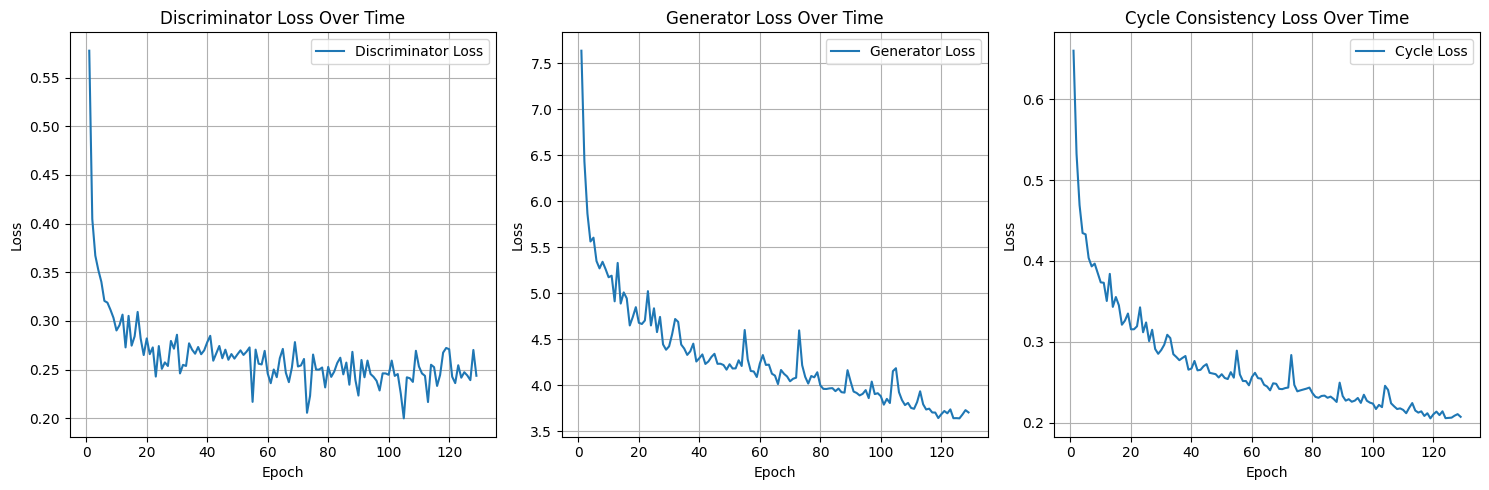


Final training statistics:
Total epochs trained: 129
Best cycle_loss: 0.205498
Training stopped early due to no improvement for 10 epochs


In [13]:
# Initialize training variables
start_epoch = 0
training_history = {
    "epoch": [],
    "discriminator_loss": [],
    "generator_loss": [],
    "cycle_loss": [],
    "minecraft_real_score": [],
    "minecraft_fake_score": [],
}

# Initialize early stopping
early_stopping = EarlyStopping(
    patience=EARLY_STOPPING_PATIENCE,
    min_delta=EARLY_STOPPING_MIN_DELTA,
    restore_best_weights=True,
)

# Check if we should load a specific checkpoint
if LOAD_CHECKPOINT is not None:
    print(f"Looking for checkpoint at epoch {LOAD_CHECKPOINT}...")
    checkpoint_path = find_specific_checkpoint(LOAD_CHECKPOINT)

    if checkpoint_path:
        print(f"Found checkpoint: {checkpoint_path}")

        # Create model and optimizer dictionaries for loading
        models = {
            "gen_minecraft": gen_minecraft,
            "gen_landscape": gen_landscape,
            "disc_minecraft": disc_minecraft,
            "disc_landscape": disc_landscape,
        }

        optimizers = {"opt_gen": opt_gen, "opt_disc": opt_disc}

        # Load checkpoint
        checkpoint_info = load_checkpoint(checkpoint_path, models, optimizers, DEVICE)

        if checkpoint_info:
            start_epoch = checkpoint_info["start_epoch"]
            training_history = checkpoint_info["training_history"]

            # Restore early stopping state if available
            early_stopping_state = checkpoint_info["early_stopping_state"]
            if early_stopping_state:
                early_stopping.best_loss = early_stopping_state.get("best_loss")
                early_stopping.counter = early_stopping_state.get("counter", 0)
                print(f"   Restored early stopping state: best_loss={early_stopping.best_loss}, counter={early_stopping.counter}")
    else:
        print(f"Checkpoint for epoch {LOAD_CHECKPOINT} not found. Starting training from scratch.")
else:
    print("No checkpoint specified. Starting fresh training.")

# Main training loop
print(f"\nStarting training from epoch {start_epoch + 1}...")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE} epochs")
print(f"Monitoring: {EARLY_STOPPING_MONITOR} with min_delta: {EARLY_STOPPING_MIN_DELTA}")

max_possible_batches = max(len(landscape_loader), len(minecraft_loader))
batches_per_epoch = min(100, max_possible_batches)  # Limit to 100 batches per epoch
print(f"Maximum possible batches: {max_possible_batches}")
print(f"Reduced batches per epoch: {batches_per_epoch}")

for epoch in range(start_epoch, MAX_EPOCHS):
    print(f"\n=== Epoch {epoch + 1}/{MAX_EPOCHS} ===")

    # Create combined data loader for this epoch
    combined_loader = create_combined_loader(landscape_loader, minecraft_loader, max_batches=batches_per_epoch)

    # Train for one epoch
    epoch_losses = train_fn(
        disc_minecraft=disc_minecraft,
        disc_landscape=disc_landscape,
        gen_landscape=gen_landscape,
        gen_minecraft=gen_minecraft,
        loader=combined_loader,
        opt_disc=opt_disc,
        opt_gen=opt_gen,
        l1=L1,
        mse=mse,
        d_scaler=d_scaler,
        g_scaler=g_scaler,
        epoch=epoch,
    )

    # Store training history
    training_history["epoch"].append(epoch + 1)
    for key, value in epoch_losses.items():
        training_history[key].append(value)

    # Print epoch summary
    print(f"Epoch {epoch + 1} Summary:")
    print(f"  Discriminator Loss: {epoch_losses['discriminator_loss']:.6f}")
    print(f"  Generator Loss: {epoch_losses['generator_loss']:.6f}")
    print(f"  Cycle Loss: {epoch_losses['cycle_loss']:.6f}")

    # Early stopping check
    monitor_loss = epoch_losses[EARLY_STOPPING_MONITOR]

    # Get current model states for potential restoration
    model_states = {
        "gen_minecraft": {k: v.cpu() for k, v in gen_minecraft.state_dict().items()},
        "gen_landscape": {k: v.cpu() for k, v in gen_landscape.state_dict().items()},
        "disc_minecraft": {k: v.cpu() for k, v in disc_minecraft.state_dict().items()},
        "disc_landscape": {k: v.cpu() for k, v in disc_landscape.state_dict().items()},
    }

    early_stopping(monitor_loss, model_states)

    if early_stopping.early_stop:
        print(f"\nEarly stopping triggered at epoch {epoch + 1}")
        print(f"Best {EARLY_STOPPING_MONITOR}: {early_stopping.best_loss:.6f}")

        # Restore best weights if available
        if early_stopping.restore_best_weights and early_stopping.best_weights is not None:
            print("Restoring best model weights...")
            gen_minecraft.load_state_dict({k: v.to(DEVICE) for k, v in early_stopping.best_weights["gen_minecraft"].items()})
            gen_landscape.load_state_dict({k: v.to(DEVICE) for k, v in early_stopping.best_weights["gen_landscape"].items()})
            disc_minecraft.load_state_dict({k: v.to(DEVICE) for k, v in early_stopping.best_weights["disc_minecraft"].items()})
            disc_landscape.load_state_dict({k: v.to(DEVICE) for k, v in early_stopping.best_weights["disc_landscape"].items()})

        break

    # Save model checkpoints at specified intervals
    if (epoch + 1) % CHECKPOINT_SAVE_INTERVAL == 0:
        checkpoint = {
            "gen_minecraft_state_dict": gen_minecraft.state_dict(),
            "gen_landscape_state_dict": gen_landscape.state_dict(),
            "disc_minecraft_state_dict": disc_minecraft.state_dict(),
            "disc_landscape_state_dict": disc_landscape.state_dict(),
            "opt_gen_state_dict": opt_gen.state_dict(),
            "opt_disc_state_dict": opt_disc.state_dict(),
            "epoch": epoch,
            "training_history": training_history,
            "early_stopping_state": {
                "best_loss": early_stopping.best_loss,
                "counter": early_stopping.counter,
                "patience": early_stopping.patience,
            },
        }
        torch.save(checkpoint, f"outputs/checkpoint_epoch_{epoch + 1}.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

print("Training completed!")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(
    training_history["epoch"],
    training_history["discriminator_loss"],
    label="Discriminator Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Over Time")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(
    training_history["epoch"],
    training_history["generator_loss"],
    label="Generator Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Over Time")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(training_history["epoch"], training_history["cycle_loss"], label="Cycle Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Cycle Consistency Loss Over Time")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nFinal training statistics:")
print(f"Total epochs trained: {len(training_history['epoch'])}")
print(f"Best {EARLY_STOPPING_MONITOR}: {early_stopping.best_loss:.6f}")
if early_stopping.early_stop:
    print(f"Training stopped early due to no improvement for {EARLY_STOPPING_PATIENCE} epochs")

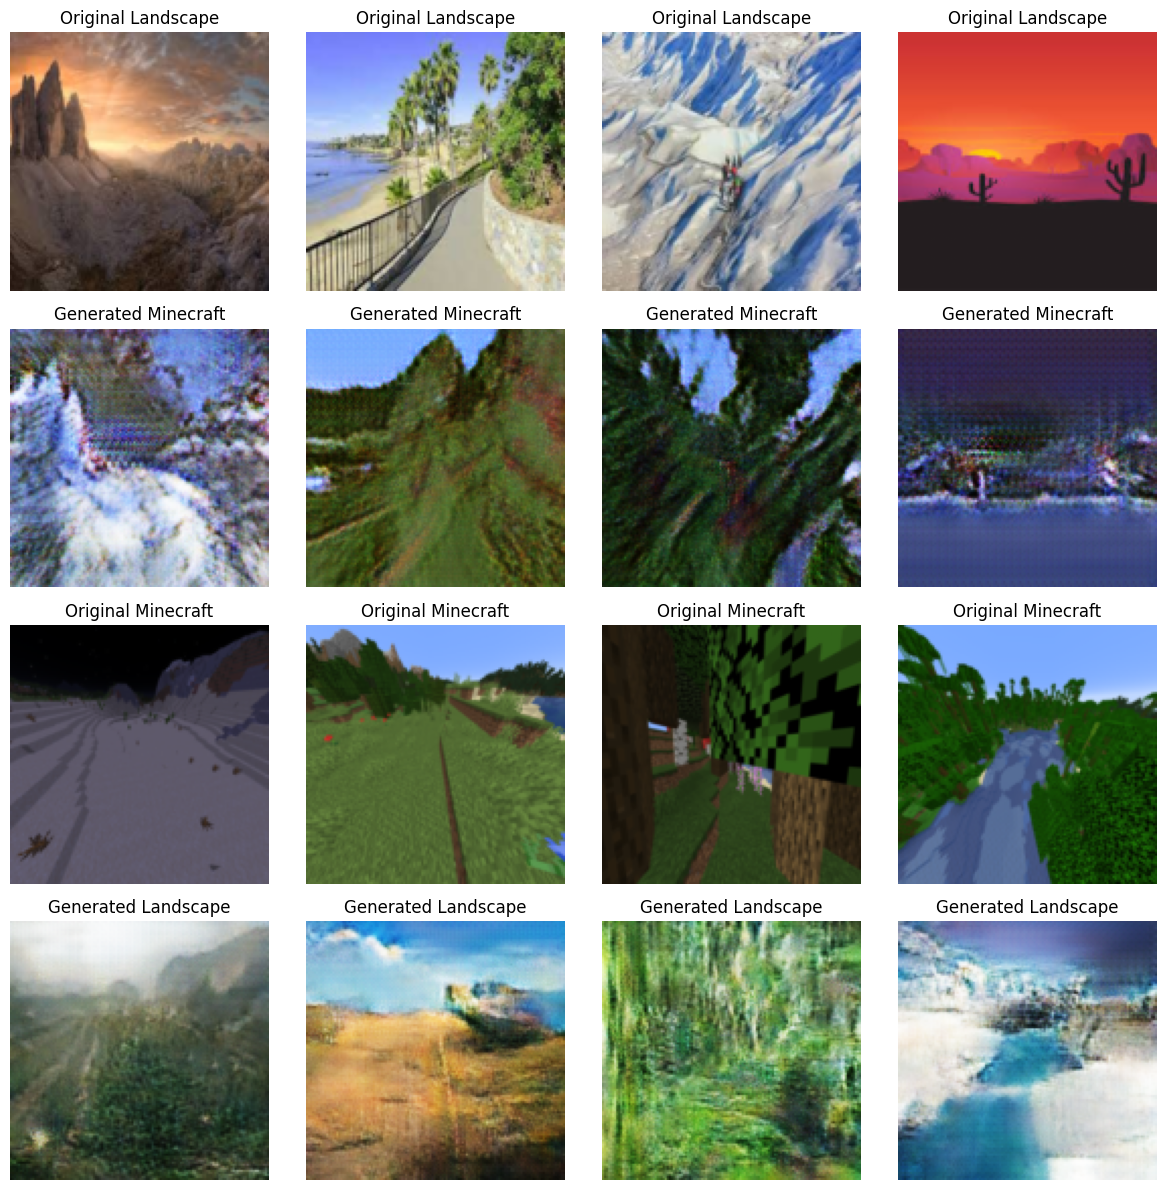

In [15]:
# Utility function to visualize results
def visualize_results(gen_minecraft, gen_landscape, landscape_batch, minecraft_batch, num_samples=4):
    """
    Visualize the results of the generators on sample batches
    """
    gen_minecraft.eval()
    gen_landscape.eval()
    
    with torch.no_grad():
        # Convert landscape to minecraft
        fake_minecraft = gen_minecraft(landscape_batch[:num_samples].to(DEVICE))
        # Convert minecraft to landscape  
        fake_landscape = gen_landscape(minecraft_batch[:num_samples].to(DEVICE))
        
        # Denormalize images for visualization (from [-1,1] to [0,1])
        landscape_viz = landscape_batch[:num_samples] * 0.5 + 0.5
        minecraft_viz = minecraft_batch[:num_samples] * 0.5 + 0.5
        fake_minecraft_viz = fake_minecraft.cpu() * 0.5 + 0.5
        fake_landscape_viz = fake_landscape.cpu() * 0.5 + 0.5
        
        # Create visualization
        fig, axes = plt.subplots(4, num_samples, figsize=(num_samples*3, 12))
        
        for i in range(num_samples):
            # Original landscape
            axes[0, i].imshow(np.transpose(landscape_viz[i].numpy(), (1, 2, 0)))
            axes[0, i].set_title('Original Landscape')
            axes[0, i].axis('off')
            
            # Generated minecraft from landscape
            axes[1, i].imshow(np.transpose(fake_minecraft_viz[i].numpy(), (1, 2, 0)))
            axes[1, i].set_title('Generated Minecraft')
            axes[1, i].axis('off')
            
            # Original minecraft
            axes[2, i].imshow(np.transpose(minecraft_viz[i].numpy(), (1, 2, 0)))
            axes[2, i].set_title('Original Minecraft')
            axes[2, i].axis('off')
            
            # Generated landscape from minecraft
            axes[3, i].imshow(np.transpose(fake_landscape_viz[i].numpy(), (1, 2, 0)))
            axes[3, i].set_title('Generated Landscape')
            axes[3, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    gen_minecraft.train()
    gen_landscape.train()

# Example usage (uncomment to test):
landscape_sample = next(iter(landscape_loader))
minecraft_sample = next(iter(minecraft_loader))
visualize_results(gen_minecraft, gen_landscape, landscape_sample, minecraft_sample)
